In [58]:
# install
%pip install vega_datasets
%pip install scipy
%pip install altair

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#imports
import pandas as pd 
 
import matplotlib.pyplot as plt 

import seaborn as sns
sns.set_theme() 

import altair as alt
from vega_datasets import data

import numpy as np
from scipy.stats import pearsonr
 
import geopandas as gpd 
import requests 
import tempfile

ModuleNotFoundError: No module named 'geopandas'

## Data Setting & Methods

For our analysis, we wanted to look at 4 main components – which required 4 different large datasets. Something we needed to think about was how we wanted to format and merge our dataframes.

For formatting, we made sure (through cleaning) that every dataset had consistent naming (i.e no ‘ County’ as a suffix) and consistent types. 

Since not every dataset had an FIPS – which is a unique identification code per County, we decided that we needed to merge on at least both State & County. 

Additionally, we wanted to look at how these components varied or correlated over time, which exponentially increased the number of rows we needed.
We settled on having a multi index that went State -> County -> Year -> Month -> Day. So while manipulating and merging the datasets was definitely tricky, once we had our combined dataframe – accessing became incredibly intuitive! 


In [ ]:
#load datasets
vaccinations = pd.read_csv("COVID-19_Vaccinations.csv", low_memory=False)
covid_cases = pd.read_csv("covid_confirmed_usafacts.csv", low_memory=False) 
death_cases = pd.read_csv("covid_deaths_usafacts.csv", low_memory=False)
gdp_by_county = pd.read_csv("GDP by County.csv", low_memory=False) 



In [ ]:
def clean_gdp_by_county(df):
    '''
    This method takes in a dataframe created from the GDP by County csv,
    then applies a cleaning process, and then returns the cleaned 
    dataframe. This dataframe makes sure to remove irrelvant (aka non-county) information.

    TODO: Write Tests
    '''
    df = df.iloc[1:]
    df = df.dropna(how='all')
    states = [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
        "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
        "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
        "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana",
        "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York",
        "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
        "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ]

    # Drop rows where the index (county) is actually a state name
    df = df[~df.index.isin(states)]
    df.set_index("County", inplace=True)
    return df
gdp_by_county = clean_gdp_by_county(gdp_by_county)


In [ ]:
def clean_vax_df(df_vax):
    '''
    This method takes in a dataframe created from the  csv,
    then applies a cleaning process, and then returns the cleaned 
    dataframe. This cleaning process involves making sure the dataframe
    has consistent naming with other dataframes, selects relevant information,
    and reformats date values.

    TODO: Write Tests
    '''
    #clean vaccination dataset
    # Convert the 'Date' column to datetime format
    df_vax["Date"] = pd.to_datetime(df_vax["Date"], format="%m/%d/%Y")

    # Extract Year, Month, and Day
    df_vax["Year"] = df_vax["Date"].dt.year
    df_vax["Month"] = df_vax["Date"].dt.month
    df_vax["Day"] = df_vax["Date"].dt.day

    df_vax["Recip_County"] = df_vax["Recip_County"].str.replace(" County", "").str.strip()

    # Rename columns to match indexing convention
    df_vax = df_vax.rename(columns={"Recip_County": "County", "Recip_State": "State"})

    # Select only relevant columns
    df_vax = df_vax[["State", "County", "Year", "Month", "Day", "Series_Complete_Yes", 
                    "Series_Complete_Pop_Pct", "Booster_Doses_Vax_Pct"]]

    # Set the multi-index
    df_vax.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_vax

vaccinations = clean_vax_df(vaccinations)

In [ ]:
def clean_cases_df(df_cases):
    '''
    This method takes in a dataframe created from the covid_confirmed_usafacts csv,
    then applies a cleaning process, and then returns the cleaned 
    dataframe. This cleaning process involves making sure the dataframe
    has consistent naming with other dataframes, 
    and reformats date values.

    TODO: Write Tests
    '''
    # Standardize county names (remove " County")
    df_cases["County Name"] = df_cases["County Name"].str.replace(" County", "").str.strip()

    # Rename columns for consistency
    df_cases = df_cases.rename(columns={"County Name": "County", "State": "State"})

    # Drop unnecessary columns
    df_cases = df_cases.drop(columns=["countyFIPS", "StateFIPS"])

    # Convert wide format (dates as columns) to long format
    df_cases = df_cases.melt(id_vars=["State", "County"], var_name="Date", value_name="Cases")

    # Convert Date column to datetime and extract Year, Month, Day
    df_cases["Date"] = pd.to_datetime(df_cases["Date"])
    df_cases["Year"] = df_cases["Date"].dt.year
    df_cases["Month"] = df_cases["Date"].dt.month
    df_cases["Day"] = df_cases["Date"].dt.day


    # Drop the original Date column
    df_cases.drop(columns=["Date"], inplace=True)
    df_cases = df_cases[df_cases["County"] != "Statewide Unallocated"]

    # Set multi-index
    df_cases.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_cases
covid_cases = clean_cases_df(covid_cases)

In [ ]:
def clean_deaths_df(df_deaths):
    '''
    This method takes in a dataframe created from the covid_deaths_usafacts csv,
    then applies a cleaning process, and then returns the cleaned 
    dataframe. This cleaning process involves making sure the dataframe
    has consistent naming with other dataframes, reformatting the structure of the dataframe,
    and reformats date values.

    TODO: Write Tests
    '''
    # Drop unnecessary columns
    df_deaths = df_deaths.drop(columns=["StateFIPS"], errors="ignore")

    # Rename columns for consistency
    df_deaths = df_deaths.rename(columns={"County Name": "County", "State": "State", "countyFIPS":"FIPS"})

    # Standardize county names (remove "County" and extra spaces)
    df_deaths["County"] = df_deaths["County"].str.replace(" County", "").str.strip()

    # Remove rows where County is "Statewide Unallocated"
    df_deaths = df_deaths[df_deaths["County"] != "Statewide Unallocated"]

    # Reshape from wide format to long format
    df_deaths = df_deaths.melt(id_vars=["State", "County", "FIPS"], var_name="Date", value_name="Deaths")

    # Convert Date column to datetime format
    df_deaths["Date"] = pd.to_datetime(df_deaths["Date"], format="%Y-%m-%d")

    # Extract Year, Month, and Day
    df_deaths["Year"] = df_deaths["Date"].dt.year
    df_deaths["Month"] = df_deaths["Date"].dt.month
    df_deaths["Day"] = df_deaths["Date"].dt.day

    # Drop the original Date column
    df_deaths.drop(columns=["Date"], inplace = True)

    # Set multi-index
    df_deaths.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_deaths
death_cases = clean_deaths_df(death_cases)

In [ ]:
def read_geojson():
    '''
    This method creates a dataframe that contains geometery and geospatial information
    for US counties. This dataframe also stores information about the coordinates
    of a county.
    '''
    # URL for a pre-converted GeoJSON of U.S. counties
    geojson_url = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'

    # Download the GeoJSON file
    response = requests.get(geojson_url)
    response.raise_for_status()

    # Save to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".json", delete=False) as tmp:
        tmp.write(response.content)
        tmp_filename = tmp.name

    # Read the GeoJSON with GeoPandas
    gdf_counties = gpd.read_file(tmp_filename)

    gdf_projected = gdf_counties.to_crs(epsg=5070)

    # Compute centroids in the projected CRS
    gdf_projected['centroid'] = gdf_projected.geometry.centroid

    # Reproject the centroids back to geographic coordinates (EPSG:4326) for Altair
    gdf_counties['centroid'] = gdf_projected['centroid'].to_crs(epsg=4326)

    # Extract longitude and latitude from the centroids
    gdf_counties['longitude'] = gdf_counties['centroid'].x
    gdf_counties['latitude'] = gdf_counties['centroid'].y

    gdf_counties['id'] = gdf_counties['id'].astype(int)
    
    return gdf_counties
gdf_counties = read_geojson()

In [ ]:
def merge_datasets():
    '''
    This method creates one large dataframe that's comprised of 4 subset
    data frames -- those being COVID cases, COVID deaths, COVID vaccination information
    and County GDP information. The combined dataframe that is created within this method
    is then returned.
    '''

    #CHANGED FROM OUTER -> INNER
    df_combined = covid_cases.merge(death_cases, on=["State", "County", "Year", "Month", "Day"], how="inner")
    df_combined = df_combined.merge(vaccinations, on=["State", "County", "Year", "Month", "Day"], how="inner")
    
    #setup so we can merge on county
    df_combined = df_combined.reset_index()
    gdp_reset = gdp_by_county.reset_index()

    df_combined = pd.merge(df_combined, gdp_reset, on="County", how="left")
    df_combined = df_combined.set_index(["State", "County", "Year", "Month", "Day"])
    
    return df_combined
df_combined = merge_datasets()

In [ ]:
def reformat_GDP(df):
    '''
    This method reformats the GDP columns in the given dataframe, as
    well as computing and storing the GDP Growth of a county over
    four years -- specifically 2020-2023.

    TODO: Test
    '''


    gdp_columns = ['GDP_20', 'GDP_21', 'GDP_22', 'GDP_23']

    # # Remove commas if present and convert each column to an integer
    for col in gdp_columns:
        df[col] =  df[col].str.replace(',', '').astype(float)  

    df['GDP_GROWTH'] = (df['GDP_23'] - df['GDP_20']) / df['GDP_20']

reformat_GDP(df_combined) #diff ver. with less rows

### Results
With the world returning to normal in a post-COVID era, it’s important to not forget the tremendous impact that COVID had. We wanted to look at the differences in how different aspects of society were affected by COVID. 

We specifically want to look into vaccination, mortality, cases, and economic trends to gain a better understanding of which areas & who were affected by COVID the most.

### Extra Plots
These plots don't correlate to a specific research question, but we thought they were still interesting visuals.

This following code cells displays a map visual of GDP growth over 2020-2023 for each county. This is interesting to
see which counties had stronger economic growth than others.

In [ ]:
def map_gdp():
    '''
    This method creates a map visualization using the large dataframe that looks into COVID case, deaths, vaccinations,
    and GDP information. Specifically, it plots a map of the US where the counties are colored based
    on their GDP Growth percentage over 2020 to 2023. 

    TODO: Test
    '''
    df = df_combined.reset_index()[["State", "County", "Year", "FIPS", "GDP_GROWTH"]] 

    df.drop_duplicates(subset=['FIPS'], keep='last', inplace=True) #most recent values

    df['Year'] = df['Year'].astype(str)

    #display(df.dtypes)
    alt.data_transformers.disable_max_rows()

    # TopoJSON of US counties
    counties = alt.topo_feature(data.us_10m.url, 'counties')


    map_chart = (
        alt.Chart(counties)
        .mark_geoshape()
        .encode(
            color='GDP_GROWTH:Q',
            tooltip=['County:N', 'State:N', 'GDP_GROWTH:Q']
        )
        .transform_lookup(
            lookup='id',    # 'id' in the counties TopoJSON is the FIPS code
            from_=alt.LookupData(df, 'FIPS', ['GDP_GROWTH', 'Year', 'State', 'County']) #'County', 'State', 'GDP', 'Year'
        )
        # .transform_filter(year_select)
        .project(type='albersUsa')
        .properties(width=700, height=400, title="GDP Growth (2020-2023)")
        #.add_params(year_select)
    )
    display(map_chart) 

map_gdp()

alt.Chart(...)

### RQ.1 How did COVID vaccination rates correlate with fatality rates across different counties?

In [ ]:
def fatality_vax_county():
    '''
    This method creates a map visualization using the large dataframe that looks into COVID case, deaths, vaccinations,
    and GDP information. Specifically, it plots a map of the US where the counties are colored based
    on their COVID fatality percentage. Additionaly, there is a a top layer that shows the vaccination percentage (which
    looks at the the percentage of a county population that got the entire vaccination series). 

    TODO: Test
    ''' 
    df = df_combined.reset_index()[["State", "County", "Year", "FIPS", "Series_Complete_Pop_Pct", "Deaths", "Cases"]]
    df['Fatality'] = df['Deaths'] / df['Cases'] * 100

    df['Year'] = df['Year'].astype(str)
    df.drop_duplicates(subset=['FIPS'], keep='last', inplace=True) #most recent


    counties = alt.topo_feature(data.us_10m.url, 'counties')
    choropleth = (
        alt.Chart(counties)
        .mark_geoshape()
        .encode(
            color=alt.Color('Fatality:Q', scale=alt.Scale(scheme='reds')),
            tooltip=[
                alt.Tooltip('County:N', title="County Name"),
                alt.Tooltip('State:N', title="State Name"),
                alt.Tooltip('Fatality:Q', title="Fatality %"),
                alt.Tooltip('Series_Complete_Pop_Pct:Q', title="Vaccination %"),
            ]
        )
        .transform_lookup(
            lookup='id',    # 'id' in the counties TopoJSON is the FIPS code
            from_=alt.LookupData(df, 'FIPS', ['State', 'County', 'Fatality', 'Series_Complete_Pop_Pct']) #'County', 'State', 'GDP', 'Year'
        )
        .project(type='albersUsa')
        .properties(width=700, height=400, title="Fatality % & Vaccination % per County")
    )
 
    gdf_counties.drop(columns=['STATE', 'COUNTY', 'NAME', 'LSAD'], inplace=True) #run once
    df = df.merge(gdf_counties, left_on='FIPS', right_on='id', how='inner') 
    df.drop(columns=['id'], inplace=True) 

    toggle = alt.param(
        name='showCircles',
        value=True,
        bind=alt.binding_checkbox(name='Show Vaccination %')
    )

    df_centroids = pd.DataFrame({
        'longitude': df['longitude'],
        'latitude': df['latitude'],
        'vax_rate': df['Series_Complete_Pop_Pct'],
        'name': df['County']        
    })

    # Create the circles layer where the circle size represents the vaccination rate.
    circles = (
        alt.Chart(df_centroids)
        .mark_circle(
        ).encode(
            longitude='longitude:Q',
            latitude='latitude:Q',
            size=alt.Size('vax_rate:Q',
                        scale=alt.Scale(range=[0, 100]),  # adjust the range as needed
                        title='Vaccination Rate'),
            tooltip=[
                alt.Tooltip('name:N', title='County'),
                alt.Tooltip('vax_rate:Q', title='Vaccination %')
            ]
        ).project(type='albersUsa')
        .add_params(toggle)
        .transform_filter(toggle) 
    )
    
    
    # display(choropleth) 
    # display(circles)
    display(choropleth + circles)
fatality_vax_county()

alt.LayerChart(...)

#### RQ.1 Cont.

So what's going on here?

Immeadiately, it's interesting to see how the variance in the density of vaccination rate circles between the 
east & west side, but through further inspection this is because of the difference in county size between
the east and west. 

What I like about this visual is that we can take in both vaccination rate & fatality rate, or just focus on one
or the other. By unchecking the the vaccination % layer, we can get some really interesting insights on what counties
or states have really high fatality rates %. Specifcally, it seems that Georgia (GA) as a whole has really high fatality rates,
with a high of 8% fatality combined with a 36.6% vaccination rate -> (another fun feature is hovering over any given
county in this visual will give you the county name, state name, fatality rate %, and vaccination rate % :D!). 

Another general correlation is that it seems like the higher the vaccination rate (above 50%), the lower the fatality rate. 
Some geographical insights include that the coasts seem to have higher vaccination rates -- which could be explained 
by differing political ideologies based on coast vs. center & urban vs. rural.

To fully answer the question, there definitely seems to be a correlaton between having a higher vaccination rate -- a higher rate 
being 50% and above -- and having a lower fatality rate.

-- Ruslana

### RQ.2 Is there a geographical trend for getting the complete vaccination series?

In [ ]:
def series_by_county():
    '''
    This method creates a map visualization using the large dataframe that looks into COVID case, deaths, vaccinations, 
    and GDP information. Specifically, it plots a map of the US where the counties are colored based 
    on their vaccination percentage (which looks at the the percentage of a county population that got the entire vaccination series).

    TODO: Test
    '''
    df = df_combined.reset_index()[['County','State','Series_Complete_Pop_Pct', 'FIPS']]
 
    df.drop_duplicates(subset=['FIPS'], keep='last', inplace=True)

    counties = alt.topo_feature(data.us_10m.url, 'counties') 
    df.dropna(subset=['County','State','Series_Complete_Pop_Pct'], inplace=True)
    

    chart = ( 
        alt.Chart(counties)
        .mark_geoshape()
        .encode( 
            color=alt.Color( 
                'Series_Complete_Pop_Pct:Q',
                scale=alt.Scale(scheme="redblue", domain=[0, 100]),
                legend=alt.Legend(title="Series Complete % per County")
            ),

            tooltip=['County:N', 'State:N', 'Series_Complete_Pop_Pct:Q']
        )
        .transform_lookup(
            lookup='id',
            from_=alt.LookupData(df, 'FIPS', ['Series_Complete_Pop_Pct', 'State', 'County'])
        )
        .project(type='albersUsa') 
        .properties(width=700, height=400, title="Vaccination Series Completed % Per County") 
    )
    display(chart)
series_by_county()

alt.Chart(...)

#### RQ.2 

Similarily to the previous visual & explanation, I feel like this visual shows a
clearer picture of the divide between rural/urban and coast/center. I will say 
part of that is due to the color scheme (which was on purpose ;) )!

A takeaway here is that it's really interesting how regional differences can influence
political ideologies -- which can influence medical decisions. 

To answer the question, I think there is definetly a geographical trend for getting 
the complete COVID vaccination series -- however I think that there is more to it then
just a difference in zip code. I feel like the difference lies in differing political ideologies,
which in turn influences who you're listening to. 

I think an interesting follow up questions would be looking at if there was a correlation in politcal ideology (i.e political party) and
getting the complete vaccination series.

-- Ruslana

### RQ.3 Did the distribution of vaccines correlate with the # of covid cases and deaths?


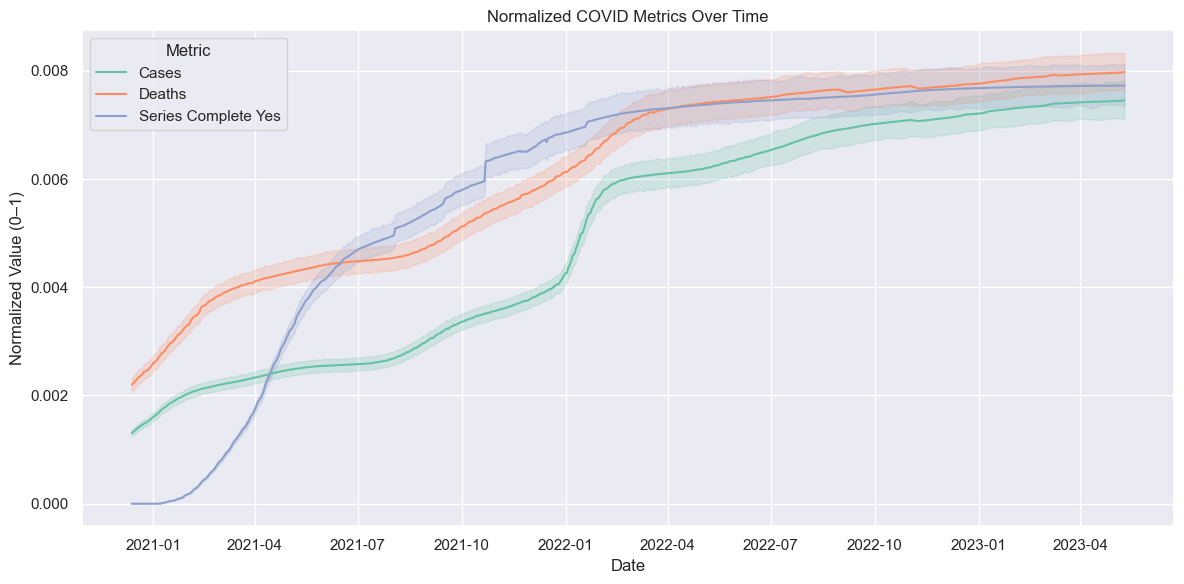

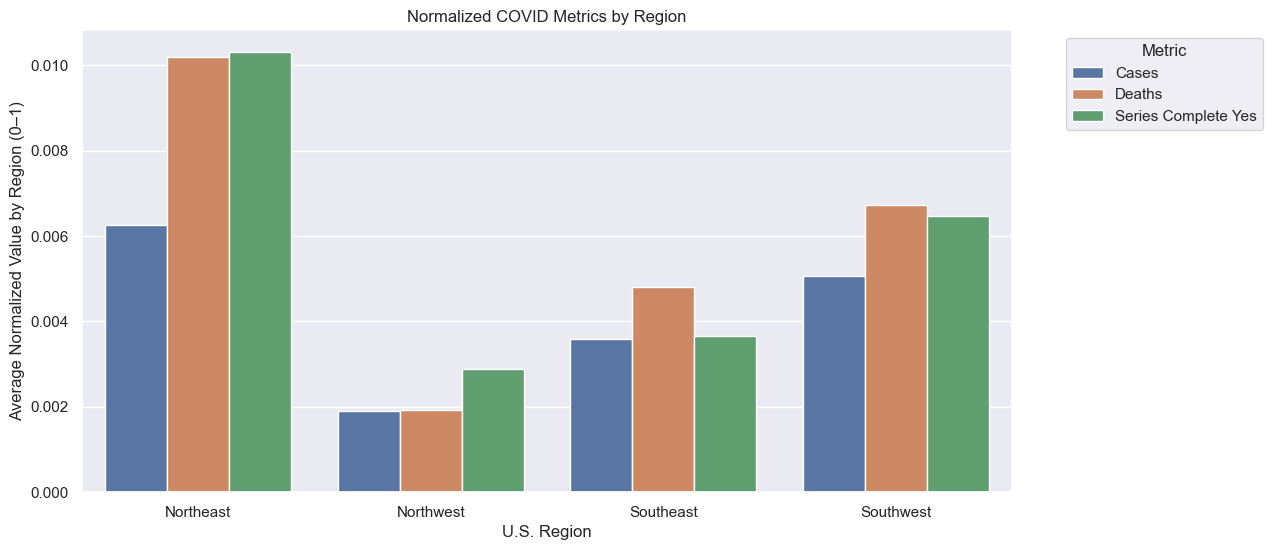

In [60]:
def normalized_time():
    '''
    This function takes strictly covid related data: case, deaths, vaccinations and their date, normilaizes
    the data then produces a line and bar plot based on the data. 

    TODO: Test
    '''
    df = df_combined.reset_index()
    df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

    metrics = ["Cases", "Deaths", "Series_Complete_Yes"]

    for col in metrics:
        df[col + "_norm"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    df_melted = df.melt( id_vars=["Date"], value_vars=[col + "_norm" for col in metrics], var_name="Metric",
        value_name="Normalized Value"
    )

    df_melted["Metric"] = df_melted["Metric"].str.replace("_norm", "").str.replace("_", " ")

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_melted, x="Date", y="Normalized Value", hue="Metric", palette="Set2")
    plt.title("Normalized COVID Metrics Over Time")
    plt.xlabel("Date")
    plt.ylabel("Normalized Value (0–1)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    northeast_states = ["ME", "NH", "VT", "MA", "RI", "CT", "NY", "NJ", "PA", "DE", "MD", "DC", "WV"]
    northwest_states = ["AK", "WA", "OR", "ID", "MT", "WY", "ND", "SD", "MN", "IA", "NE", "KS"]

    southeast_states = ["KY", "TN", "VA", "NC", "SC", "GA", "FL", "AL", "MS", "AR", "LA", "OK", "TX"]

    southwest_states = ["HI", "CA", "NV", "UT", "AZ", "NM", "CO", "MO", "WI", "IL", "IN", "OH"]

    state_to_region = {}
    for state in northeast_states:
        state_to_region[state] = "Northeast"
    for state in northwest_states:
        state_to_region[state] = "Northwest"
    for state in southeast_states:
        state_to_region[state] = "Southeast"
    for state in southwest_states:
        state_to_region[state] = "Southwest"

    df["Region"] = df["State"].map(state_to_region)

    df_region_grouped = df.groupby("Region")[[col + "_norm" for col in metrics]].mean().reset_index()

    df_region_melted = df_region_grouped.melt(id_vars="Region", var_name="Metric", value_name="Normalized Value")
    df_region_melted["Metric"] = df_region_melted["Metric"].str.replace("_norm", "").str.replace("_", " ")

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_region_melted, x= "Region", y = "Normalized Value",hue= "Metric")

    plt.title("Normalized COVID Metrics by Region")
    plt.xlabel("U.S. Region")
    plt.ylabel("Average Normalized Value by Region (0–1)")
    plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
normalized_time()

def rese_ques_3_test():
    df = df_combined.reset_index()
    df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

    metrics = ["Cases", "Deaths", "Series_Complete_Yes"]
    normalized_columns = ["Cases_norm", "Deaths_norm", "Series_Complete_Yes_norm"]

    for col in metrics:
        norm_col = col + "_norm"
        df[norm_col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    for col in normalized_columns:
        if col not in df.columns:
            raise AssertionError(col + " is missing from dataframe")
        if df[col].isnull().all():
            raise AssertionError(col + " contains only NaN values")

    northeast_states = ["ME", "NH", "VT", "MA", "RI", "CT", "NY", "NJ", "PA", "DE", "MD", "DC", "WV"]
    northwest_states = ["AK", "WA", "OR", "ID", "MT", "WY", "ND", "SD", "MN", "IA", "NE", "KS"]

    southeast_states = ["KY", "TN", "VA", "NC", "SC", "GA", "FL", "AL", "MS", "AR", "LA", "OK", "TX"]

    southwest_states = ["HI", "CA", "NV", "UT", "AZ", "NM", "CO", "MO", "WI", "IL", "IN", "OH"]

    state_to_region = {} 
    for state in northeast_states:
        state_to_region[state] = "Northeast"
    for state in northwest_states:
        state_to_region[state] = "Northwest" 
    for state in southeast_states: 
        state_to_region[state] = "Southeast"
    for state in southwest_states:
        state_to_region[state] = "Southwest"

    df["Region"] = df["State"].map(state_to_region)

    assert "Region" in df.columns, "Region column missing"

    assert not df[df["Region"] == "Northwest"].empty, "No data found for Northwest region"

    wa_rows = df[df["State"] == "WA"]
    assert wa_rows[wa_rows["Region"] == "Southwest"], "Washington (WA) was incorrectly assigned to Southwest"

#### RQ.3 Cont.
### How can we encapsulate as much available data in analysis
So the first thing that came up after us discussing our topic and finding some preliminary datasets was the fact that our data was limited to right about 4 years. This became an imidiete concern. And so with this final research question, we really wanted to think hard and try to make the most out of our covid data set. Our families were deeply affected by covid. Benya's high school was the first to close because of a covid infection and that was a traumatic experience. And really what gave the idea for a covid data driven project was that it was miss handled and we wanted to show it. Large emphasis on vaccinations. 

Upon figuring out the best way to graph the countries vaccine, covid cases and deaths, you can make some observations.
First thing we saw was that, where the vaccine line started at 0, the cases and deaths had a positive y-intercept. And this made sense because there needed some time for vaccines to be created and tested and ultimately distributed. Another observation that we were just so eager to see was whether or not vaccinations put a dent in deaths and number of cases. Which as it can be observed in the line graph, it did. You can see both deaths and cases, plateaued for a bit. Now the theory that Benya has is that indeed, vaccines placed faith in those, or even those around them who received them, to return to their old life ultimately leading to a greater spread of the virus. Another possibility, the two theory's can coexist, it was during this time that poorer lesser equipped rural areas gained access to technologies and were mandated by the FDA to record statistics for their jurisdiction. And this makes sense because the greatest increase in cases recorded came right after the plateau. 
Now there remains one last very obvious observation to be made which is that 'how come there's less cases recorded than deaths?'. Two theories, it's hard to keep count of cases when people survive qurantine, but it's definitive when they have lung inflammation after passing leading to more deaths recorded than cases. Secondly, people and institutions where not really keeping track of cases. Until a little later through the pandemic. 

This could partially explain why we have less cases than deaths when that's not actually possible. To end this part talking about result, we came up with another method of going deeper with our three variables, specifically region based data we came up with another method of going deeper with our three variables, specifically region based data, and used the same normalized dataset across the board, and then grouped by region. 

Just looking at this bar graph was so satisfying. Like before we didn't have an instance where number of cases were more than number of deaths but the northwest region came strikingly close. Another observation that can be made the northwest which included state: AK, WA, OR and who had vaccinated their population at much larger margin relative to deaths, calculated by Benya looking and guestimating, experienced lower over all deaths and cases. 

Now I understand that less people live here but my analysis is that you see a much lower trend in deaths, as observed by the fact that death has been higher than cases in all other regions, when the population is vaccinated. Now, we know that the data is flawed in that the cases is less than deaths, but regaurdless there's a trend with all the other regions that the northwest seems to uniquely lack. South west and both east coast regions have the highest number of states which due to idealogical and spread of missinformation were less keen on getting everyone vaccinated which lead to a worse, if ever existing, herd immunity. A principle which says when enough people are immune, the disease has a hard time spreading because there are fewer susceptible hosts. 

You will observe 2 plots. A line plot for the Normalized covid Deaths, Cases, and Vaccines over time. The first halve of the discussion above goes over the bar graph. Secondly you'll observe a bar graph, also normalized covid metrics. 51 states + DC have been divided in to sub regions, and using group by, all data is shared from the line plot. The second part of the discussion above goes over observations of the bar plot. 

### Implications & Limitations
*Who might benefit from your analysis and who might be excluded or otherwise harmed by it?*

An unintended takeway from our analysis was looking at how individuals are influenced, particularly into following (or ignoring) medical advice. 
More broadly, it seems like region definitely influenced individuals. 

So who benefits? Who is excluded?
I think that that depends on interpretations and biases that are projected onto the data (the data could potentially have it's own
influences -- but we'll talk about that in data setting). If you're looking at the analysis through the lens of 'How can increase vaccination
rates in areas that are historically low', it would make sense if you focused on rural/center areas -- potentially ignoring urban/coastal areas.

Additionally, understanding what (or who) influences what demographic is a huge factor in marketing. By understanding your audience, you 
understand how to effectively pander to them. 

Taking a step back, you can also apply a need based approach. For example, by looking at counties with the high fatality rates, you
(as a government organization) can prioritize who should be helped first. But another question arises -- who decides cutoffs? And what about
states with low fatality rates -- do those not matter just because they're low? 

*What about the data setting might have impacted your results?*
For data setting, we were limited with the number of datasets that we had access to. Additionally, we were
further limited to datasets that weren't recorded over time, or were only recorded over years and not months.

This can potentially introduce some error in our dataset where are data for a given month or a given year is not 
entirely accurate.

Additionally, with datasets this large, some trimming was needed to be done since my partner and I don't have computers
powerful enough to fully render/visualize all the information

*Explain at least 3 limitations of your analysis and how others should or shouldn't be advised to use your conclusions.*

1.) While our analysis could potentially be incrediby helpful for prioritizing need, this comes with a caution -- how
do we decide how to priortize?
2.) Since a majority of our analysis points to regional differences, a caution is that we shouldn't be rash
with stereotyping a region a certain way.
3.) A limitation with our data is that we can only track trends until 2023 and starting in 2020, so we are only 
lookign at a small window.